In [1]:
%pip install pytorch-ignite

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
from torchvision import datasets
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize, ToPILImage, RandomHorizontalFlip
from torch.utils.data import random_split, DataLoader, Dataset
from torch import nn

from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Engine
from ignite.metrics import Accuracy, Loss, Precision, Recall

import pandas as pd

import matplotlib.pyplot as plt
import os.path

from PIL import Image

from IPython.display import clear_output

to_tensor = PILToTensor()
to_image = ToPILImage()

In [10]:
class LungDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.lung_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.lung_frame) - 1

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, 'img_%d.png' % self.lung_frame.iloc[idx, 0])
        lungs = self.lung_frame.iloc[idx, 1]
        sample = Image.open(img_name)

        if self.transform:
            sample = self.transform(sample)

        return (sample, lungs)

In [11]:
class LungCrop(object):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir

    def __call__(self, sample):
        fname = os.path.basename(sample.filename)
        img_name = os.path.join(self.root_dir, fname)

        sample = to_tensor(sample)
        mask = to_tensor(Image.open(img_name))
        
        sample = sample * (mask > 100).int()
        
        return sample.float()

1


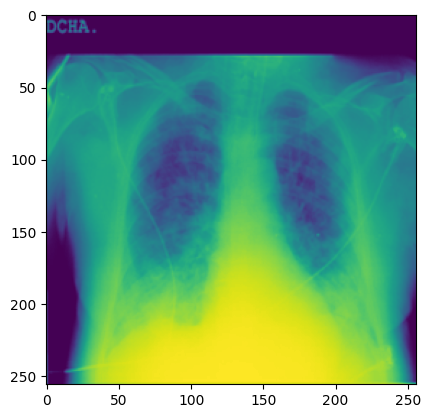

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = Compose([
    #LungCrop('data/train_lung_masks')
    PILToTensor(),
    ToDtype(torch.float32, scale=True)
])

dataset = LungDataset('data/train_answers.csv', 'data/train_images', transform=transform)

train_set, test_set = random_split(dataset, (0.90, 0.1))
plt.imshow(to_image(dataset[4][0]))
print(dataset[4][1])

In [16]:
model = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(-3),
            nn.Linear(64 * 16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        ).to(device)

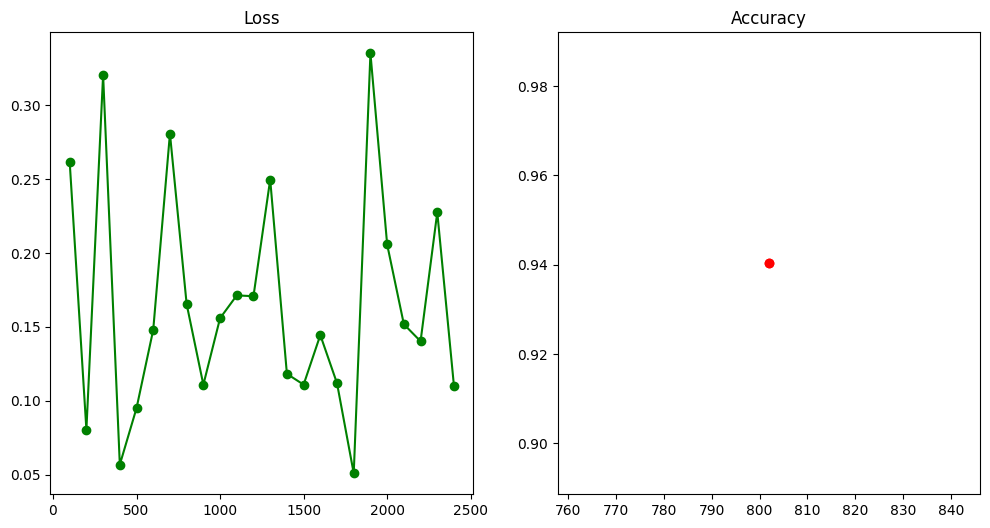

[802, 802]
Train Res: accuracy = 0.9403118908382067, precision = 0.9390189546885003, recall = 0.939083205517635, f1-score = 0.9388217773763126, loss = 0.16215839348806044
Valid Res: accuracy = 0.933283914010378, precision = 0.9328901093102937, recall = 0.9326665202529876, f1-score = 0.9325939459013878, loss = 0.17128611706732996


State:
	iteration: 2406
	epoch: 3
	epoch_length: 802
	max_epochs: 3
	output: 0.09058108180761337
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [31]:
train_set, test_set = random_split(dataset, (0.95, 0.05))

model.load_state_dict(torch.load("model.mdl"))

optimizer = torch.optim.SGD(model.parameters(), lr=10**-9)
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=32, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, num_workers=2)

from ignite.engine import Events

y_cords, x_cords = [], []
y1_cords, x1_cords = [], []


def log_iter_loss(engine):
    x_cords.append(engine.state.iteration)
    y_cords.append(engine.state.output)

    clear_output()
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(x_cords, y_cords, 'go-')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(x1_cords, y1_cords, 'ro-')
    plt.show()

def compute_epoch_results(engine):
    train_evaluator.run(train_loader)
    valid_evaluator.run(test_loader)

def log_epoch_results(engine, label=""):
    if label == 'Train':
        print(x1_cords)
        x1_cords.append(engine.state.iteration)
        y1_cords.append(engine.state.metrics['accuracy'])

    result = ', '.join([f"{m} = {v}" for m, v in engine.state.metrics.items()])
    print(f"{label} Res:", result)

trainer = create_supervised_trainer(model, optimizer, criterion, device)

metrics = {
    "accuracy": Accuracy(),
    "precision": Precision().mean(),
    "recall": Recall().mean(),
    "f1-score": ((Precision() * Recall() * 2) / (Precision() + Recall())).mean(),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=100), log_iter_loss)
trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)
train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid")

print('Working')
trainer.run(train_loader, 3)

In [32]:
torch.save(model.state_dict(), "model.mdl")

In [7]:
model.load_state_dict(torch.load("model.mdl"))

<All keys matched successfully>

In [33]:
import os

with open('solution.csv', 'w') as f:
    f.write('id,target_feature\n')
    for i in range(6920):
        fname = os.path.join('data/test_images', f"img_{i}.png")
        tens = transform(Image.open(fname))
        r = torch.argmax(model(tens.to(device))).item()
        f.write('%d,%d\n' % (i, r))
        if i % 1000 == 999:
            print(i)
    f.flush()
            

999
1999
2999
3999
4999
5999
